In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/#19_GAN_and_Auto_Encoder")

In [3]:
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

In [4]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [5]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [6]:
ginput = Input(shape=(100,))

dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [7]:
def gan_train(epoch, batch_size, saving_interval):

  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28 ,28, 1).astype('float32')

  X_train = (X_train - 127.5) / 127.5
  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch:%d' %i, ' d_loss:%.4f' %d_loss, ' g_loss:%.4f' %g_loss)

    if i % saving_interval == 0:
      noise = np.random.normal(0, 1, (25, 100))
      gen_imgs = generator.predict(noise)

      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
          fig.savefig('gan_images/gan_mnist%d.png' %i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 18ms/step
epoch:1508  d_loss:0.4902  g_loss:1.4977
1/1 [==============================] - 0s 19ms/step
epoch:1509  d_loss:0.4486  g_loss:1.5591
1/1 [==============================] - 0s 20ms/step
epoch:1510  d_loss:0.4916  g_loss:1.5047
1/1 [==============================] - 0s 19ms/step
epoch:1511  d_loss:0.5410  g_loss:1.5340
1/1 [==============================] - 0s 19ms/step
epoch:1512  d_loss:0.4394  g_loss:1.5028
1/1 [==============================] - 0s 18ms/step
epoch:1513  d_loss:0.3226  g_loss:1.5726
1/1 [==============================] - 0s 20ms/step
epoch:1514  d_loss:0.5027  g_loss:1.4055
1/1 [==============================] - 0s 20ms/step
epoch:1515  d_loss:0.3998  g_loss:1.9026
1/1 [==============================] - 0s 20ms/step
epoch:1516  d_loss:0.5456  g_loss:1.6000
1/1 [==============================] - 0s 25ms/step
epoch:1517  d_loss:0.5155  g_loss:1.3834
1/1 [=============================

<ipython-input-7-7511760768f1>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 5)


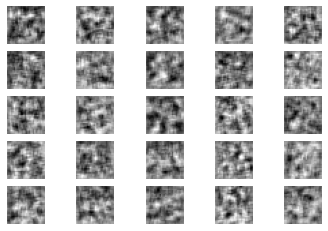

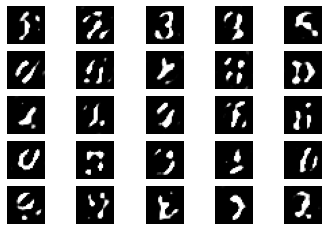

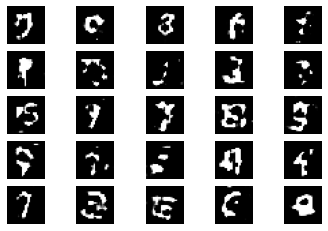

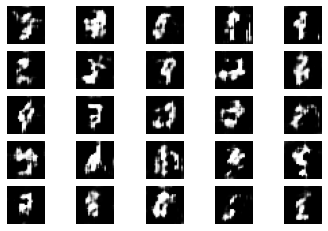

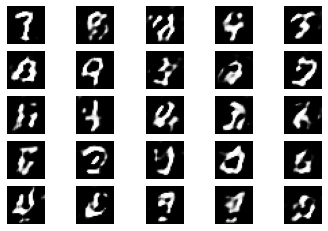

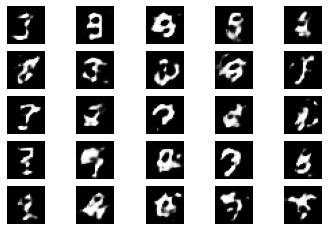

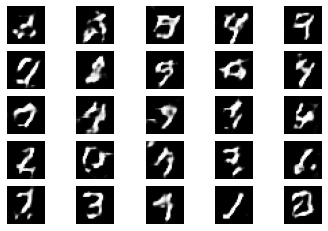

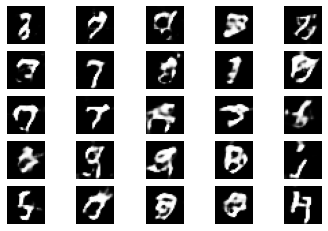

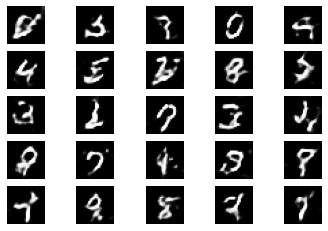

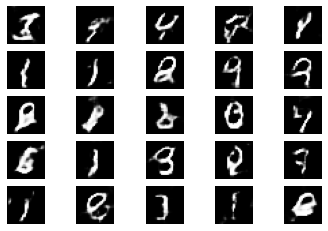

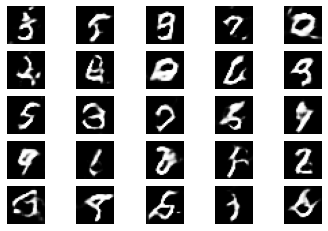

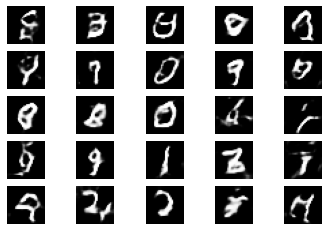

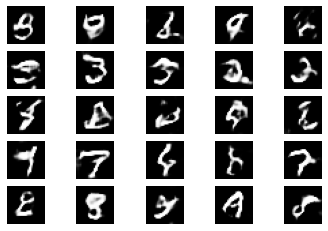

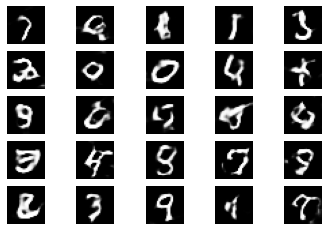

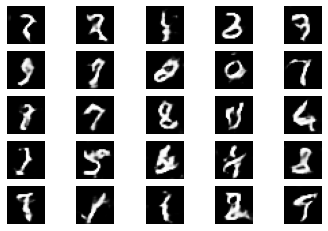

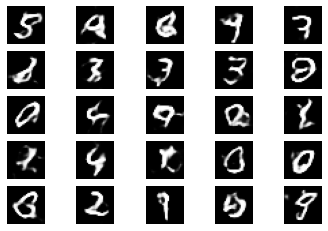

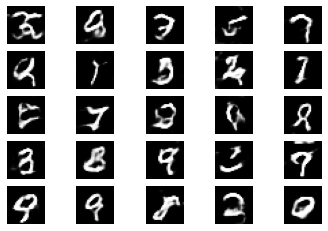

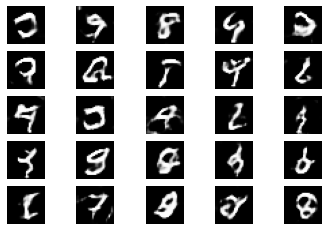

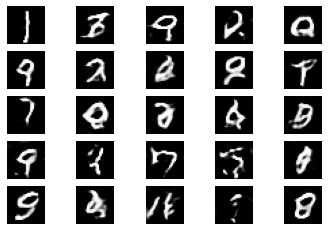

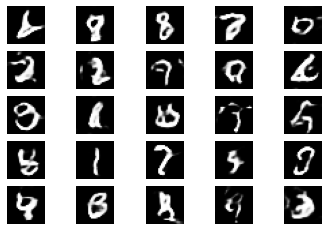

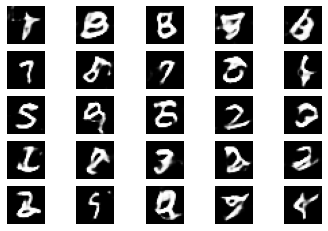

In [8]:
gan_train(4001, 32, 200)